In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import glob

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

# Hyperparameters
timestep = 16
split = 80
sample = 10
epochs = 80
batch_size=128
to_keep = [0,0,0,0,0,0,1,1,1,1,0,0,0,1,1,1,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,1,1,1,0,0,0]

2024-04-15 11:38:34.633852: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-15 11:38:35.332902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-15 11:38:35.349668: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-15 11:38:35.349752: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [92]:
# Build dataset
path = '/media/rmhri/mrom/data/dataset49+' # For pw3d
files = glob.glob(path + '/*.csv')

final_X = []
final_y = []
test_X = []
test_y = []

for filename in files:
    file = np.loadtxt(filename,delimiter=',')
    file = file[:,np.array(to_keep).astype(bool)]
    X = []
    y = []
    for j in range(file.shape[0] - timestep):
        seq = file[j: j + timestep + 1]
        in_seq = seq[:-1].tolist()
        out = seq.tolist()[-1]
        X.append(in_seq)
        y.append(out)

    if len(X) > sample:
        subset_index = np.random.choice(list(range(0, len(X))),size = sample, replace = False)
        X = [X[i] for i in subset_index]
        y = [y[i] for i in subset_index]

    if not filename.__contains__("MPI_Limits"):
        final_X += X
        final_y += y
    else:
        test_X += X
        test_y += y
        # print(filename)


subset_index = np.random.choice(list(range(0, len(final_X))),size = len(final_X), replace = False)
final_X = [final_X[i] for i in subset_index]
final_y = [final_y[i] for i in subset_index]
X = np.array(final_X)/np.pi
y = np.array(final_y)/np.pi

split_index = int(len(X) * 0.8)  # 80% training, 20% validation
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y[:split_index], y[split_index:]

np.save( '/media/rmhri/mrom/data/train_dataset/X_train_' + str(timestep) + '_' + str(sample)+  '_angle.npy', X_train)
np.save( '/media/rmhri/mrom/data/train_dataset/X_val_'   + str(timestep) + '_' + str(sample)+  '_angle.npy', X_val)
np.save( '/media/rmhri/mrom/data/train_dataset/y_train_' + str(timestep) + '_' + str(sample)+  '_angle.npy', y_train)
np.save( '/media/rmhri/mrom/data/train_dataset/y_val_'   + str(timestep) + '_' + str(sample)+  '_angle.npy', y_val)
np.save( '/media/rmhri/mrom/data/train_dataset/y_test_' + str(timestep) + '_' + str(sample)+  '_angle.npy', test_y)
np.save( '/media/rmhri/mrom/data/train_dataset/X_test_'   + str(timestep) + '_' + str(sample)+  '_angle.npy', test_X)


In [93]:
# Build the model architecture
X_train = np.load('/media/rmhri/mrom/data/train_dataset/X_train_' + str(timestep) + '_' + str(sample)+  '_angle.npy')
y_train = np.load('/media/rmhri/mrom/data/train_dataset/y_train_' + str(timestep) + '_' + str(sample)+  '_angle.npy')
X_val =   np.load('/media/rmhri/mrom/data/train_dataset/X_val_' + str(timestep) + '_' + str(sample)+  '_angle.npy')
y_val =   np.load('/media/rmhri/mrom/data/train_dataset/y_val_' + str(timestep) + '_' + str(sample)+  '_angle.npy')

model_path = '/media/rmhri/mrom/data/model/angle_'+str(timestep)+"_"+str(sample)
checkpoint = ModelCheckpoint(model_path, monitor='val_mae', verbose=0, save_best_only=True, mode = 'min')
callbacks_list = [checkpoint]

model = keras.Sequential(
    [
    layers.GRU(1024, return_sequences=True ,input_shape=(timestep,20)),
    layers.Dropout(0.1),
	layers.GRU(1024, return_sequences=False),
    # layers.Dropout(0.1),
    layers.Dense(20)
    ]
)

model.summary()
opt = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=opt, loss="mse", metrics=["mae"])
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, validation_data=(X_val,y_val) , callbacks=callbacks_list
                    )
# model.save(model_path)

model.save(model_path+".h5",save_format="h5")
 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 16, 1024)          3213312   
                                                                 
 dropout (Dropout)           (None, 16, 1024)          0         
                                                                 
 gru_1 (GRU)                 (None, 1024)              6297600   
                                                                 
 dense (Dense)               (None, 20)                20500     
                                                                 
Total params: 9,531,412
Trainable params: 9,531,412
Non-trainable params: 0
_________________________________________________________________
Epoch 1/80
38/40 [===========================>..] - ETA: 0s - loss: 0.0219 - mae: 0.0951

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 4s 74ms/step - loss: 0.0215 - mae: 0.0941 - val_loss: 0.0122 - val_mae: 0.0711
Epoch 2/80
37/40 [==========================>...] - ETA: 0s - loss: 0.0092 - mae: 0.0635

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 69ms/step - loss: 0.0091 - mae: 0.0633 - val_loss: 0.0065 - val_mae: 0.0553
Epoch 3/80
38/40 [===========================>..] - ETA: 0s - loss: 0.0058 - mae: 0.0525

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 62ms/step - loss: 0.0057 - mae: 0.0522 - val_loss: 0.0044 - val_mae: 0.0456
Epoch 4/80
37/40 [==========================>...] - ETA: 0s - loss: 0.0041 - mae: 0.0441

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 71ms/step - loss: 0.0040 - mae: 0.0438 - val_loss: 0.0032 - val_mae: 0.0390
Epoch 5/80
37/40 [==========================>...] - ETA: 0s - loss: 0.0031 - mae: 0.0384

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 63ms/step - loss: 0.0031 - mae: 0.0382 - val_loss: 0.0025 - val_mae: 0.0345
Epoch 6/80
39/40 [============================>.] - ETA: 0s - loss: 0.0025 - mae: 0.0342

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 70ms/step - loss: 0.0025 - mae: 0.0342 - val_loss: 0.0020 - val_mae: 0.0310
Epoch 7/80
40/40 [==============================] - ETA: 0s - loss: 0.0020 - mae: 0.0309

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 62ms/step - loss: 0.0020 - mae: 0.0309 - val_loss: 0.0017 - val_mae: 0.0281
Epoch 8/80
37/40 [==========================>...] - ETA: 0s - loss: 0.0017 - mae: 0.0282

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 70ms/step - loss: 0.0017 - mae: 0.0281 - val_loss: 0.0014 - val_mae: 0.0257
Epoch 9/80
38/40 [===========================>..] - ETA: 0s - loss: 0.0014 - mae: 0.0258

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 68ms/step - loss: 0.0014 - mae: 0.0258 - val_loss: 0.0012 - val_mae: 0.0237
Epoch 10/80
38/40 [===========================>..] - ETA: 0s - loss: 0.0012 - mae: 0.0239

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 63ms/step - loss: 0.0012 - mae: 0.0238 - val_loss: 0.0011 - val_mae: 0.0219
Epoch 11/80
39/40 [============================>.] - ETA: 0s - loss: 0.0011 - mae: 0.0222

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 70ms/step - loss: 0.0011 - mae: 0.0222 - val_loss: 9.4355e-04 - val_mae: 0.0204
Epoch 12/80
36/40 [==========================>...] - ETA: 0s - loss: 9.4786e-04 - mae: 0.0206

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 67ms/step - loss: 9.5111e-04 - mae: 0.0207 - val_loss: 8.4266e-04 - val_mae: 0.0191
Epoch 13/80
37/40 [==========================>...] - ETA: 0s - loss: 8.4913e-04 - mae: 0.0194

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 63ms/step - loss: 8.5027e-04 - mae: 0.0194 - val_loss: 7.6078e-04 - val_mae: 0.0180
Epoch 14/80
36/40 [==========================>...] - ETA: 0s - loss: 7.7366e-04 - mae: 0.0184

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 70ms/step - loss: 7.6645e-04 - mae: 0.0183 - val_loss: 6.9219e-04 - val_mae: 0.0169
Epoch 15/80
37/40 [==========================>...] - ETA: 0s - loss: 7.0225e-04 - mae: 0.0173

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 63ms/step - loss: 6.9945e-04 - mae: 0.0173 - val_loss: 6.3618e-04 - val_mae: 0.0160
Epoch 16/80
37/40 [==========================>...] - ETA: 0s - loss: 6.4949e-04 - mae: 0.0166

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 70ms/step - loss: 6.4639e-04 - mae: 0.0165 - val_loss: 5.9063e-04 - val_mae: 0.0152
Epoch 17/80
36/40 [==========================>...] - ETA: 0s - loss: 6.0560e-04 - mae: 0.0158

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 60ms/step - loss: 6.0217e-04 - mae: 0.0157 - val_loss: 5.5386e-04 - val_mae: 0.0146
Epoch 18/80
37/40 [==========================>...] - ETA: 0s - loss: 5.7006e-04 - mae: 0.0151

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 69ms/step - loss: 5.6475e-04 - mae: 0.0151 - val_loss: 5.2287e-04 - val_mae: 0.0139
Epoch 19/80
37/40 [==========================>...] - ETA: 0s - loss: 5.3532e-04 - mae: 0.0146

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 68ms/step - loss: 5.3462e-04 - mae: 0.0145 - val_loss: 4.9510e-04 - val_mae: 0.0134
Epoch 20/80
39/40 [============================>.] - ETA: 0s - loss: 5.1182e-04 - mae: 0.0141

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 62ms/step - loss: 5.0941e-04 - mae: 0.0140 - val_loss: 4.7266e-04 - val_mae: 0.0128
Epoch 21/80
37/40 [==========================>...] - ETA: 0s - loss: 4.8315e-04 - mae: 0.0136

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 70ms/step - loss: 4.8524e-04 - mae: 0.0136 - val_loss: 4.5364e-04 - val_mae: 0.0124
Epoch 22/80
35/40 [=========================>....] - ETA: 0s - loss: 4.6665e-04 - mae: 0.0132

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 62ms/step - loss: 4.6759e-04 - mae: 0.0132 - val_loss: 4.3741e-04 - val_mae: 0.0120
Epoch 23/80
38/40 [===========================>..] - ETA: 0s - loss: 4.4992e-04 - mae: 0.0128

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 70ms/step - loss: 4.5095e-04 - mae: 0.0128 - val_loss: 4.2309e-04 - val_mae: 0.0117
Epoch 24/80
39/40 [============================>.] - ETA: 0s - loss: 4.3749e-04 - mae: 0.0125

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 68ms/step - loss: 4.3678e-04 - mae: 0.0125 - val_loss: 4.1141e-04 - val_mae: 0.0114
Epoch 25/80
38/40 [===========================>..] - ETA: 0s - loss: 4.2371e-04 - mae: 0.0123

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 62ms/step - loss: 4.2561e-04 - mae: 0.0123 - val_loss: 3.9922e-04 - val_mae: 0.0111
Epoch 26/80
38/40 [===========================>..] - ETA: 0s - loss: 4.1580e-04 - mae: 0.0120

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 71ms/step - loss: 4.1413e-04 - mae: 0.0120 - val_loss: 3.9148e-04 - val_mae: 0.0108
Epoch 27/80
39/40 [============================>.] - ETA: 0s - loss: 4.0267e-04 - mae: 0.0118

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 62ms/step - loss: 4.0476e-04 - mae: 0.0118 - val_loss: 3.8177e-04 - val_mae: 0.0106
Epoch 28/80
38/40 [===========================>..] - ETA: 0s - loss: 3.9784e-04 - mae: 0.0116

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 70ms/step - loss: 3.9718e-04 - mae: 0.0116 - val_loss: 3.7394e-04 - val_mae: 0.0104
Epoch 29/80
37/40 [==========================>...] - ETA: 0s - loss: 3.9205e-04 - mae: 0.0115

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 68ms/step - loss: 3.9138e-04 - mae: 0.0115 - val_loss: 3.6871e-04 - val_mae: 0.0103
Epoch 30/80
37/40 [==========================>...] - ETA: 0s - loss: 3.8288e-04 - mae: 0.0113

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 63ms/step - loss: 3.8299e-04 - mae: 0.0113 - val_loss: 3.6240e-04 - val_mae: 0.0101
Epoch 31/80
37/40 [==========================>...] - ETA: 0s - loss: 3.7426e-04 - mae: 0.0112

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 70ms/step - loss: 3.7676e-04 - mae: 0.0112 - val_loss: 3.5493e-04 - val_mae: 0.0099
Epoch 32/80
36/40 [==========================>...] - ETA: 0s - loss: 3.6754e-04 - mae: 0.0110

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 61ms/step - loss: 3.7219e-04 - mae: 0.0111 - val_loss: 3.5034e-04 - val_mae: 0.0098
Epoch 33/80
39/40 [============================>.] - ETA: 0s - loss: 3.6957e-04 - mae: 0.0110

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 69ms/step - loss: 3.6740e-04 - mae: 0.0110 - val_loss: 3.4438e-04 - val_mae: 0.0097
Epoch 34/80
35/40 [=========================>....] - ETA: 0s - loss: 3.7129e-04 - mae: 0.0109

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 67ms/step - loss: 3.6115e-04 - mae: 0.0108 - val_loss: 3.3994e-04 - val_mae: 0.0096
Epoch 35/80
39/40 [============================>.] - ETA: 0s - loss: 3.5704e-04 - mae: 0.0107

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 62ms/step - loss: 3.5537e-04 - mae: 0.0107 - val_loss: 3.3560e-04 - val_mae: 0.0095
Epoch 36/80
38/40 [===========================>..] - ETA: 0s - loss: 3.5140e-04 - mae: 0.0107

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 70ms/step - loss: 3.5074e-04 - mae: 0.0107 - val_loss: 3.3167e-04 - val_mae: 0.0094
Epoch 37/80
37/40 [==========================>...] - ETA: 0s - loss: 3.5370e-04 - mae: 0.0106

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 63ms/step - loss: 3.4826e-04 - mae: 0.0106 - val_loss: 3.2691e-04 - val_mae: 0.0093
Epoch 38/80
37/40 [==========================>...] - ETA: 0s - loss: 3.4726e-04 - mae: 0.0105

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 70ms/step - loss: 3.4270e-04 - mae: 0.0105 - val_loss: 3.2354e-04 - val_mae: 0.0092
Epoch 39/80
39/40 [============================>.] - ETA: 0s - loss: 3.4142e-04 - mae: 0.0105

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 69ms/step - loss: 3.3916e-04 - mae: 0.0104 - val_loss: 3.1843e-04 - val_mae: 0.0091
Epoch 40/80
37/40 [==========================>...] - ETA: 0s - loss: 3.2954e-04 - mae: 0.0103

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 63ms/step - loss: 3.3285e-04 - mae: 0.0103 - val_loss: 3.1466e-04 - val_mae: 0.0090
Epoch 41/80
38/40 [===========================>..] - ETA: 0s - loss: 3.3252e-04 - mae: 0.0103

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 71ms/step - loss: 3.3006e-04 - mae: 0.0102 - val_loss: 3.0948e-04 - val_mae: 0.0089
Epoch 42/80
40/40 [==============================] - ETA: 0s - loss: 3.2730e-04 - mae: 0.0102

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 62ms/step - loss: 3.2730e-04 - mae: 0.0102 - val_loss: 3.0718e-04 - val_mae: 0.0089
Epoch 43/80
40/40 [==============================] - ETA: 0s - loss: 3.2337e-04 - mae: 0.0101

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 70ms/step - loss: 3.2337e-04 - mae: 0.0101 - val_loss: 3.0228e-04 - val_mae: 0.0088
Epoch 44/80
40/40 [==============================] - ETA: 0s - loss: 3.1891e-04 - mae: 0.0100

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 67ms/step - loss: 3.1891e-04 - mae: 0.0100 - val_loss: 2.9805e-04 - val_mae: 0.0087
Epoch 45/80
38/40 [===========================>..] - ETA: 0s - loss: 3.1584e-04 - mae: 0.0100

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 61ms/step - loss: 3.1509e-04 - mae: 0.0100 - val_loss: 2.9512e-04 - val_mae: 0.0086
Epoch 46/80
37/40 [==========================>...] - ETA: 0s - loss: 3.0938e-04 - mae: 0.0099

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 71ms/step - loss: 3.1059e-04 - mae: 0.0099 - val_loss: 2.9112e-04 - val_mae: 0.0086
Epoch 47/80
39/40 [============================>.] - ETA: 0s - loss: 3.0844e-04 - mae: 0.0099

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 68ms/step - loss: 3.0660e-04 - mae: 0.0098 - val_loss: 2.8830e-04 - val_mae: 0.0085
Epoch 48/80
37/40 [==========================>...] - ETA: 0s - loss: 3.0667e-04 - mae: 0.0098

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 62ms/step - loss: 3.0327e-04 - mae: 0.0098 - val_loss: 2.8527e-04 - val_mae: 0.0085
Epoch 49/80
36/40 [==========================>...] - ETA: 0s - loss: 3.0223e-04 - mae: 0.0098

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 70ms/step - loss: 3.0045e-04 - mae: 0.0097 - val_loss: 2.8142e-04 - val_mae: 0.0084
Epoch 50/80
38/40 [===========================>..] - ETA: 0s - loss: 3.0318e-04 - mae: 0.0097

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 63ms/step - loss: 2.9831e-04 - mae: 0.0097 - val_loss: 2.7738e-04 - val_mae: 0.0083
Epoch 51/80
40/40 [==============================] - ETA: 0s - loss: 2.9345e-04 - mae: 0.0096

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 68ms/step - loss: 2.9345e-04 - mae: 0.0096 - val_loss: 2.7335e-04 - val_mae: 0.0082
Epoch 52/80
37/40 [==========================>...] - ETA: 0s - loss: 2.9189e-04 - mae: 0.0095

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 63ms/step - loss: 2.9093e-04 - mae: 0.0095 - val_loss: 2.7077e-04 - val_mae: 0.0082
Epoch 53/80
37/40 [==========================>...] - ETA: 0s - loss: 2.8869e-04 - mae: 0.0095

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 70ms/step - loss: 2.8622e-04 - mae: 0.0095 - val_loss: 2.6761e-04 - val_mae: 0.0081
Epoch 54/80
37/40 [==========================>...] - ETA: 0s - loss: 2.8668e-04 - mae: 0.0095

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 67ms/step - loss: 2.8338e-04 - mae: 0.0094 - val_loss: 2.6423e-04 - val_mae: 0.0081
Epoch 55/80
40/40 [==============================] - ETA: 0s - loss: 2.8188e-04 - mae: 0.0094

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 62ms/step - loss: 2.8188e-04 - mae: 0.0094 - val_loss: 2.6203e-04 - val_mae: 0.0080
Epoch 56/80
37/40 [==========================>...] - ETA: 0s - loss: 2.7874e-04 - mae: 0.0093

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 70ms/step - loss: 2.7867e-04 - mae: 0.0093 - val_loss: 2.5918e-04 - val_mae: 0.0080
Epoch 57/80
38/40 [===========================>..] - ETA: 0s - loss: 2.7922e-04 - mae: 0.0093

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 62ms/step - loss: 2.7628e-04 - mae: 0.0093 - val_loss: 2.5550e-04 - val_mae: 0.0079
Epoch 58/80
39/40 [============================>.] - ETA: 0s - loss: 2.7250e-04 - mae: 0.0092

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 70ms/step - loss: 2.7262e-04 - mae: 0.0092 - val_loss: 2.5201e-04 - val_mae: 0.0078
Epoch 59/80
38/40 [===========================>..] - ETA: 0s - loss: 2.6376e-04 - mae: 0.0091

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 68ms/step - loss: 2.6931e-04 - mae: 0.0092 - val_loss: 2.4969e-04 - val_mae: 0.0078
Epoch 60/80
37/40 [==========================>...] - ETA: 0s - loss: 2.6710e-04 - mae: 0.0091

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 62ms/step - loss: 2.6644e-04 - mae: 0.0091 - val_loss: 2.4710e-04 - val_mae: 0.0078
Epoch 61/80
40/40 [==============================] - 0s 12ms/step - loss: 2.6401e-04 - mae: 0.0091 - val_loss: 2.4513e-04 - val_mae: 0.0078
Epoch 62/80
38/40 [===========================>..] - ETA: 0s - loss: 2.6132e-04 - mae: 0.0090

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 71ms/step - loss: 2.6049e-04 - mae: 0.0090 - val_loss: 2.4077e-04 - val_mae: 0.0077
Epoch 63/80
36/40 [==========================>...] - ETA: 0s - loss: 2.6256e-04 - mae: 0.0091

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 62ms/step - loss: 2.5839e-04 - mae: 0.0090 - val_loss: 2.3900e-04 - val_mae: 0.0076
Epoch 64/80
40/40 [==============================] - ETA: 0s - loss: 2.5590e-04 - mae: 0.0089

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 70ms/step - loss: 2.5590e-04 - mae: 0.0089 - val_loss: 2.3557e-04 - val_mae: 0.0076
Epoch 65/80
39/40 [============================>.] - ETA: 0s - loss: 2.5351e-04 - mae: 0.0089

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 67ms/step - loss: 2.5256e-04 - mae: 0.0089 - val_loss: 2.3208e-04 - val_mae: 0.0076
Epoch 66/80
39/40 [============================>.] - ETA: 0s - loss: 2.4992e-04 - mae: 0.0089

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 62ms/step - loss: 2.4982e-04 - mae: 0.0089 - val_loss: 2.2960e-04 - val_mae: 0.0075
Epoch 67/80
39/40 [============================>.] - ETA: 0s - loss: 2.4671e-04 - mae: 0.0088

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 70ms/step - loss: 2.4583e-04 - mae: 0.0088 - val_loss: 2.2748e-04 - val_mae: 0.0074
Epoch 68/80
40/40 [==============================] - ETA: 0s - loss: 2.4476e-04 - mae: 0.0088

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 63ms/step - loss: 2.4476e-04 - mae: 0.0088 - val_loss: 2.2479e-04 - val_mae: 0.0074
Epoch 69/80
38/40 [===========================>..] - ETA: 0s - loss: 2.4405e-04 - mae: 0.0087

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 70ms/step - loss: 2.4151e-04 - mae: 0.0087 - val_loss: 2.2194e-04 - val_mae: 0.0074
Epoch 70/80
38/40 [===========================>..] - ETA: 0s - loss: 2.3717e-04 - mae: 0.0087

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 68ms/step - loss: 2.3931e-04 - mae: 0.0087 - val_loss: 2.1879e-04 - val_mae: 0.0073
Epoch 71/80
38/40 [===========================>..] - ETA: 0s - loss: 2.3394e-04 - mae: 0.0086

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 63ms/step - loss: 2.3587e-04 - mae: 0.0086 - val_loss: 2.1591e-04 - val_mae: 0.0073
Epoch 72/80
37/40 [==========================>...] - ETA: 0s - loss: 2.3079e-04 - mae: 0.0086

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 71ms/step - loss: 2.3252e-04 - mae: 0.0086 - val_loss: 2.1426e-04 - val_mae: 0.0072
Epoch 73/80
39/40 [============================>.] - ETA: 0s - loss: 2.2870e-04 - mae: 0.0085

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 63ms/step - loss: 2.3094e-04 - mae: 0.0086 - val_loss: 2.1205e-04 - val_mae: 0.0072
Epoch 74/80
38/40 [===========================>..] - ETA: 0s - loss: 2.2836e-04 - mae: 0.0085

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 70ms/step - loss: 2.2708e-04 - mae: 0.0085 - val_loss: 2.0899e-04 - val_mae: 0.0072
Epoch 75/80
38/40 [===========================>..] - ETA: 0s - loss: 2.2701e-04 - mae: 0.0085

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 69ms/step - loss: 2.2532e-04 - mae: 0.0085 - val_loss: 2.0607e-04 - val_mae: 0.0071
Epoch 76/80
40/40 [==============================] - ETA: 0s - loss: 2.2406e-04 - mae: 0.0084

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 61ms/step - loss: 2.2406e-04 - mae: 0.0084 - val_loss: 2.0398e-04 - val_mae: 0.0071
Epoch 77/80
37/40 [==========================>...] - ETA: 0s - loss: 2.2117e-04 - mae: 0.0084

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 70ms/step - loss: 2.2118e-04 - mae: 0.0084 - val_loss: 2.0100e-04 - val_mae: 0.0070
Epoch 78/80
38/40 [===========================>..] - ETA: 0s - loss: 2.1872e-04 - mae: 0.0083

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 2s 62ms/step - loss: 2.1937e-04 - mae: 0.0084 - val_loss: 1.9849e-04 - val_mae: 0.0070
Epoch 79/80
37/40 [==========================>...] - ETA: 0s - loss: 2.1608e-04 - mae: 0.0083

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 70ms/step - loss: 2.1625e-04 - mae: 0.0083 - val_loss: 1.9576e-04 - val_mae: 0.0069
Epoch 80/80
37/40 [==========================>...] - ETA: 0s - loss: 2.1310e-04 - mae: 0.0083

INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


INFO:tensorflow:Assets written to: /media/rmhri/mrom/data/model/angle_16_10/assets


40/40 [==============================] - 3s 68ms/step - loss: 2.1433e-04 - mae: 0.0083 - val_loss: 1.9547e-04 - val_mae: 0.0069


In [2]:
import matplotlib.pyplot as plt

# Test
X_train = np.load('/media/rmhri/mrom/data/train_dataset/X_train_' + str(timestep) + '_' + str(sample)+  '_angle.npy')
y_train = np.load('/media/rmhri/mrom/data/train_dataset/y_train_' + str(timestep) + '_' + str(sample)+  '_angle.npy')
X_val =   np.load('/media/rmhri/mrom/data/train_dataset/X_val_' + str(timestep) + '_' + str(sample)+  '_angle.npy')
y_val =   np.load('/media/rmhri/mrom/data/train_dataset/y_val_' + str(timestep) + '_' + str(sample)+  '_angle.npy')
X_test =   np.load('/media/rmhri/mrom/data/train_dataset/X_test_' + str(timestep) + '_' + str(sample)+  '_angle.npy')
y_test =   np.load('/media/rmhri/mrom/data/train_dataset/y_test_' + str(timestep) + '_' + str(sample)+  '_angle.npy')

model_path = '/media/rmhri/mrom/data/model/angle_'+str(timestep)+"_"+str(sample)

model = keras.models.load_model(model_path + ".h5")
X_test.shape

i = 0

# results = model.evaluate(X_test, y_test, batch_size=128)
# print("test loss, test acc:", results)

out = model(X_test[i,:,:].reshape(1,timestep,20))

print(np.round(180*out.numpy(),1))
print(np.round(180*y_test[i],1))
print(np.round(180*out.numpy().squeeze() - 180*y_test[i] ,2))

2024-04-15 11:38:57.166296: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 11:38:57.168003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-15 11:38:57.168118: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-04-15 11:38:57.168162: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA

[[ 7.000e+00 -9.900e+00  2.710e+01  4.800e+00 -1.010e+01 -4.000e-01
  -3.200e+00 -1.600e+01 -5.900e+00 -1.280e+01 -1.190e+01 -1.240e+01
  -9.550e+01 -1.944e+02  1.985e+02  4.366e+02  1.460e+01 -1.641e+02
  -6.360e+01  6.570e+01]]
[   7.5   -7.2   28.7    4.    -9.3    0.    -4.   -16.2   -7.   -15.7
  -13.   -14.7  -96.8 -203.5  205.2  446.9   15.1 -166.   -64.6   68.2]
[ -0.51  -2.7   -1.61   0.85  -0.73  -0.41   0.82   0.21   1.17   2.83
   1.11   2.31   1.24   9.07  -6.73 -10.35  -0.5    1.99   1.01  -2.51]


2024-04-15 11:38:58.769166: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2024-04-15 11:38:58.831142: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [3]:
# Try with simple Polynomial fitting
from numpy.polynomial import Polynomial

polynomial_fits = []
for k in range(20):  # Iterazione su ciascuna variabile
    p = Polynomial.fit(range(timestep), X_test[i,:,k], 5)  # Fitting di un polinomio di grado 3
    polynomial_fits.append(p)
next_time_step = timestep + 1
predicted_values = np.array([p(next_time_step) for p in polynomial_fits])
print(np.round(180*predicted_values,1))

[   7.5   -7.2   28.7    3.9   -9.3    0.    -4.   -16.2   -7.   -15.7
  -13.   -14.7  -96.7 -203.5  205.2  447.    15.1 -166.   -64.6   68.3]


In [4]:
# Quantitative evaluation on test set
err_nn = []
err_pp = []
for t in range(X_test.shape[0]):
    nn = model(X_test[t,:,:].reshape(1,timestep,20)).numpy()
    polynomial_fits = []
    for k in range(20):  # Iterazione su ciascuna variabile
        p = Polynomial.fit(range(timestep), X_test[t,:,k], 5)  # Fitting di un polinomio di grado 3
        polynomial_fits.append(p)
    pp = np.array([p(timestep+1) for p in polynomial_fits])
    print("NN:",np.round(np.mean(abs(nn-y_test[t]))*180,1),"\tPF:",np.round(np.mean(abs(pp-y_test[t]))*180,1))
    err_nn.append(abs(nn-y_test[t]))
    err_pp.append(abs(pp-y_test[t]))
print("\n")

print("NN:",np.round(np.mean(np.array(err_nn))*180,1),"\tPF:",np.round(np.mean(np.array(err_pp))*180,1))

NN: 2.4 	PF: 0.0
NN: 4.4 	PF: 0.1
NN: 3.0 	PF: 0.4
NN: 3.4 	PF: 0.5
NN: 2.7 	PF: 0.0
NN: 4.1 	PF: 0.1
NN: 4.4 	PF: 0.3
NN: 4.1 	PF: 0.0
NN: 2.9 	PF: 0.2
NN: 1.9 	PF: 0.0
NN: 1.6 	PF: 0.5
NN: 4.7 	PF: 1.2
NN: 7.4 	PF: 1.5
NN: 9.2 	PF: 0.5
NN: 2.2 	PF: 0.6
NN: 3.2 	PF: 0.2
NN: 5.9 	PF: 0.2
NN: 7.9 	PF: 0.6
NN: 3.2 	PF: 0.2
NN: 2.8 	PF: 0.4
NN: 3.1 	PF: 0.0
NN: 2.9 	PF: 0.9
NN: 3.0 	PF: 0.7
NN: 4.3 	PF: 0.7
NN: 7.4 	PF: 2.0
NN: 1.7 	PF: 0.6
NN: 7.1 	PF: 1.4
NN: 2.3 	PF: 0.2
NN: 2.4 	PF: 0.0
NN: 2.4 	PF: 1.1
NN: 5.8 	PF: 0.3
NN: 5.4 	PF: 0.3
NN: 5.2 	PF: 0.4
NN: 7.6 	PF: 0.1
NN: 3.1 	PF: 0.0
NN: 6.3 	PF: 0.6
NN: 5.8 	PF: 0.2
NN: 6.0 	PF: 0.3
NN: 5.8 	PF: 0.1
NN: 7.0 	PF: 0.4
NN: 3.2 	PF: 0.1
NN: 3.6 	PF: 0.1
NN: 3.7 	PF: 0.4
NN: 3.5 	PF: 0.2
NN: 3.7 	PF: 0.1
NN: 3.6 	PF: 0.1
NN: 3.5 	PF: 0.2
NN: 3.4 	PF: 0.2
NN: 3.8 	PF: 0.3
NN: 2.3 	PF: 0.1
NN: 2.8 	PF: 0.5
NN: 2.2 	PF: 0.2
NN: 11.6 	PF: 2.5
NN: 6.8 	PF: 1.7
NN: 2.5 	PF: 0.3
NN: 3.2 	PF: 0.4
NN: 2.3 	PF: 0.5
NN: 9.2 	PF: 11.3
NN: 4.3 	PF:

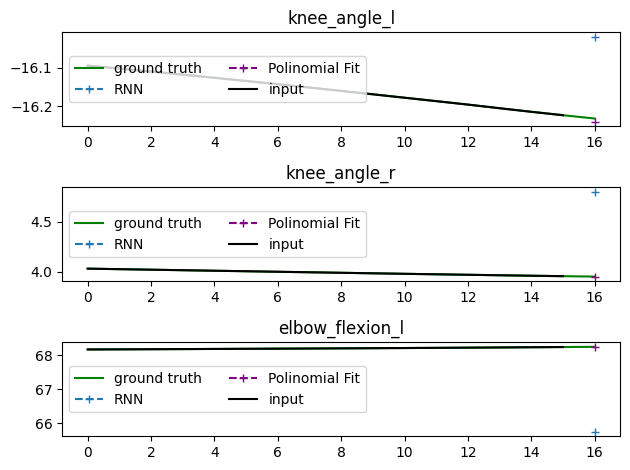

In [35]:
# Qualitative Plot
dofs = ['pelvis_tilt', 'pelvis_list', 'pelvis_rotation', 'pelvis_tx',\
 'pelvis_ty', 'pelvis_tz', 'hip_flexion_r', 'hip_adduction_r',\
 'hip_rotation_r', 'knee_angle_r', 'ankle_angle_r', 'subtalar_angle_r',\
 'mtp_angle_r', 'hip_flexion_l', 'hip_adduction_l', 'hip_rotation_l',\
 'knee_angle_l', 'ankle_angle_l', 'subtalar_angle_l', 'mtp_angle_l',\
 'lumbar_bending', 'lumbar_extension', 'lumbar_twist', 'thorax_bending',\
 'thorax_extension', 'thorax_twist', 'head_bending', 'head_extension',\
 'head_twist', 'scapula_abduction_r', 'scapula_elevation_r',\
 'scapula_upward_rot_r', 'shoulder_r_x', 'shoulder_r_y', 'shoulder_r_z',\
 'elbow_flexion_r', 'pro_sup_r', 'wrist_flexion_r', 'wrist_deviation_r',\
 'scapula_abduction_l', 'scapula_elevation_l', 'scapula_upward_rot_l',\
 'shoulder_l_x', 'shoulder_l_y', 'shoulder_l_z', 'elbow_flexion_l',\
 'pro_sup_l', 'wrist_flexion_l', 'wrist_deviation_l']

limits = {}
for k in range(len(to_keep)):
    if to_keep[k] == 1:
        limits[dofs[k]] = {
            "l" : np.nan,
            "u" : np.nan
        }

limits['hip_flexion_r']["u"] = 140
limits['hip_flexion_r']["l"] = -40
limits['hip_adduction_r']["u"] = 45
limits['hip_adduction_r']["l"] = -45
limits['hip_rotation_r']["u"] = 45
limits['hip_rotation_r']["l"] = -45
limits['knee_angle_r']["u"] = 140
limits['knee_angle_r']["l"] = -10
limits['hip_flexion_l']["u"] = 140
limits['hip_flexion_l']["l"] = -40
limits['hip_adduction_l']["u"] = 45
limits['hip_adduction_l']["l"] = -45
limits['hip_rotation_l']["u"] = 45
limits['hip_rotation_l']["l"] = -45
limits['knee_angle_l']["u"] = 140
limits['knee_angle_l']["l"] = -10
limits['lumbar_bending']["u"] = 20
limits['lumbar_bending']["l"] = -20
limits['lumbar_twist']["u"] = 5
limits['lumbar_twist']["l"] = -5
limits['thorax_bending']["u"] = 20
limits['thorax_bending']["l"] = -20
limits['thorax_twist']["u"] = 5
limits['thorax_twist']["l"] = -5
limits['shoulder_r_x']["u"] = 0
limits['shoulder_r_x']["l"] = -150
limits['shoulder_r_y']["u"] = 90
limits['shoulder_r_y']["l"] = -70
limits['shoulder_r_z']["u"] = 180
limits['shoulder_r_z']["l"] = -60
limits['elbow_flexion_r']["u"] = 154
limits['elbow_flexion_r']["l"] = -6
# limits['pro_sup_r']["u"] = np.nan
# limits['pro_sup_r']["l"] = np.nan
limits['shoulder_l_x']["u"] = 150
limits['shoulder_l_x']["l"] = 0
limits['shoulder_l_y']["u"] = 70
limits['shoulder_l_y']["l"] = -90
limits['shoulder_l_z']["u"] = 180
limits['shoulder_l_z']["l"] = -60
limits['elbow_flexion_l']["u"] = 154
limits['elbow_flexion_l']["l"] = -6
# limits['pro_sup_l']["u"] = np.nan
# limits['pro_sup_l']["l"] = np.nan

IN  = np.vstack([X_test[i,:,:],20*[np.nan]])
OUT = np.vstack([np.full_like(X_test[i,:,:], np.nan),out])
PF3 = np.vstack([np.full_like(X_test[i,:,:], np.nan),predicted_values])
GT = np.vstack([X_test[i,:,:],y_test[i,:]])


# 20 2D subplots
# plt.figure(figsize=(15, 20))
# fig,axs = plt.subplots(4,5)
# fig.suptitle('angle_'+str(timestep)+"_"+str(sample))
# for j in range(20):
#     axs[int(j/5),int(j%5)].plot(GT[:,j]*180,color="green")
#     axs[int(j/5),int(j%5)].plot(OUT[:,j]*180)
#     axs[int(j/5),int(j%5)].plot(IN[:,j]*180,color="black")
#     axs[int(j/5),int(j%5)].set_title(list(limits.keys())[j])
#     # axs[int(j/5),int(j%5)].set_ylim(limits[list(limits.keys())[j]]["l"],limits[list(limits.keys())[j]]["u"])
# # Show plot
# plt.tight_layout()
# plt.savefig('tmp/photo.png')
# plt.show()

fig,axs = plt.subplots(3,1)

js = [7,3,19]
for n_j,j in enumerate(js):
    axs[n_j].plot(GT[:,j]*180,color="green", label='ground truth')
    axs[n_j].plot(OUT[:,j]*180,marker='+', linestyle='dashed', label='RNN')
    axs[n_j].plot(PF3[:,j]*180,color="purple",marker='+', linestyle='dashed', label='Polinomial Fit')
    axs[n_j].plot(IN[:,j]*180,color="black", label='input')
    axs[n_j].set_title(list(limits.keys())[j])
    axs[n_j].legend(ncols=2,loc='center left')

# axs.set_ylim(limits[list(limits.keys())[j]]["l"],limits[list(limits.keys())[j]]["u"])

plt.tight_layout()
plt.savefig('tmp/photo.png')
plt.show()
